In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/Project/3D_UNet_menisc_seg/scripts/

/content/gdrive/MyDrive/Project/3D_UNet_menisc_seg/scripts


In [3]:
!pip install segment_anything
!pip install connected-components-3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 30.4 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
import cc3d
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
import glob
import os
import sys
sys.path.append('../src')
from datasets import KneeSegDataset3D
from utils import crop_im

In [5]:
# Define data path
DATA_DIR = '../data'

# Get the paths
train_paths = np.array([os.path.basename(i).split('.')[0] for i in glob.glob(f'{DATA_DIR}/train/*.im')])
val_paths = np.array([os.path.basename(i).split('.')[0] for i in glob.glob(f'{DATA_DIR}/valid/*.im')])
test_paths = np.array([os.path.basename(i).split('.')[0] for i in glob.glob(f'{DATA_DIR}/test/*.im')])

In [6]:
!ls $DATA_DIR

bruh.tar		   frozen_enc_test_preds    train		    unet_test_preds
data.md			   frozen_final_test_preds  train_copy.tar.gz	    valid
end2end_bce_test_preds	   ground-truth		    train_slice_gts	    valid_copy.tar.gz
end2end_final_test_preds   __MACOSX		    train_slice_gts.tar.gz  valid_slice_gts
end2end_test_preds	   test			    train_slice_ims	    valid_slice_gts.tar.gz
final_unet_aug_test_preds  test_copy.tar.gz	    train_slice_ims.tar.gz  valid_slice_ims
final_unet_test_preds	   test_gt_copy.zip	    unet_sweep_test_preds   valid_slice_ims.tar.gz


In [7]:
# Get data
train_dataset = KneeSegDataset3D(train_paths, DATA_DIR)
val_dataset = KneeSegDataset3D(val_paths, DATA_DIR, split='valid')
test_dataset = KneeSegDataset3D(test_paths, DATA_DIR, split='test')

# combine train/val
train_val_dataset = ConcatDataset([train_dataset,val_dataset])

# dataloaders
train_val_loader = DataLoader(train_val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [8]:
im, gt = next(iter(test_loader))
im = im.squeeze(0).squeeze(0).numpy()
gt = gt.squeeze(0).squeeze(0).numpy()

In [9]:
gt.shape

(200, 256, 160)

In [10]:
connectivity = 26
labels, num_labels = cc3d.connected_components(gt, connectivity = connectivity, return_N=True)

In [11]:
# Display the number of detected components
print("Number of connected components:", num_labels)

Number of connected components: 2


In [12]:
# Stats and the like
stats = cc3d.statistics(labels)

In [13]:
stats['voxel_counts']

array([8122813,   31314,   37873], dtype=uint32)

In [14]:
total = -1 # take away background
for count in stats['voxel_counts']:
  if count>1:
    total+=1

print(total)

2


In [15]:
# Extract binary masks for the different objects
objs = []
for i in range(num_labels):
    objs.append((labels == i+1).astype(np.uint8))

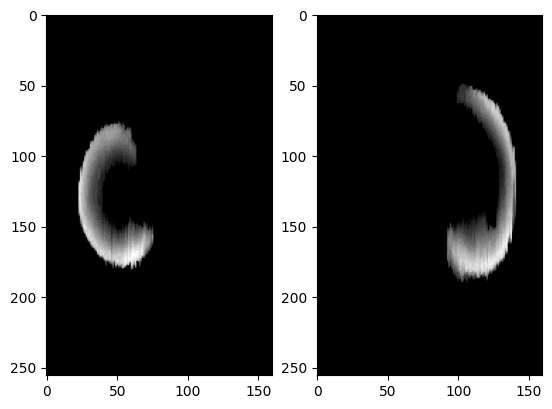

In [16]:
# display each component
import matplotlib.pyplot as plt
plt.subplots(1, len(objs))
for obj_num in range(len(objs)):
  plt.subplot(1, len(objs), obj_num+1)
  plt.imshow(np.sum(objs[obj_num],axis=0), cmap = 'gray')
plt.show()

In [17]:
!ls $DATA_DIR

bruh.tar		   frozen_enc_test_preds    train		    unet_test_preds
data.md			   frozen_final_test_preds  train_copy.tar.gz	    valid
end2end_bce_test_preds	   ground-truth		    train_slice_gts	    valid_copy.tar.gz
end2end_final_test_preds   __MACOSX		    train_slice_gts.tar.gz  valid_slice_gts
end2end_test_preds	   test			    train_slice_ims	    valid_slice_gts.tar.gz
final_unet_aug_test_preds  test_copy.tar.gz	    train_slice_ims.tar.gz  valid_slice_ims
final_unet_test_preds	   test_gt_copy.zip	    unet_sweep_test_preds   valid_slice_ims.tar.gz


In [18]:
# For each path in test_paths, I want to check connected components of GT, and model predictions
dirs = ['ground-truth', 'frozen_final_test_preds', 'end2end_bce_test_preds', 'final_unet_aug_test_preds']

In [19]:
# store number of connected components for each directory here
connected_comps = {k: [] for k in dirs}

In [24]:
min_vol = 5
connectivity = 26

# cycle through test paths
for path in test_paths:

  # cycle through dirs
  for dir in dirs:
    seg_path = os.path.join(DATA_DIR, dir, path + '.npy')
    mask = np.load(seg_path)

    # ground truth is different size so take meniscus
    if len(mask.shape) != 3:
      mask = mask[...,-1]

    # Calculate connected components for given mask and append result to relevant dictionary entry
    labels, num_labels = cc3d.connected_components(mask, connectivity = connectivity, return_N=True)

    # ignore components below a certain voxel count
    stats = cc3d.statistics(labels)

    total = -1 # take away background
    for count in stats['voxel_counts']:
      if count >= min_vol:
        total+=1

    connected_comps[dir].append(total)

In [25]:
for i in connected_comps:
  print(f"{i}: {connected_comps[i]}")

ground-truth: [2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
frozen_final_test_preds: [54, 66, 77, 82, 49, 85, 53, 23, 107, 65, 132, 95, 89, 59, 101, 110, 79, 136, 63, 43, 66, 91, 101, 63, 72, 103, 57, 71, 19, 12, 14, 14, 6, 16, 11, 10, 19, 16, 23, 10, 21, 10, 22, 17, 15, 23, 13, 10, 19, 19, 19, 13, 21, 18, 14, 13]
end2end_bce_test_preds: [12, 12, 25, 20, 6, 22, 17, 8, 24, 19, 19, 21, 9, 23, 20, 17, 21, 23, 4, 8, 9, 8, 26, 8, 17, 12, 6, 7, 7, 3, 9, 6, 3, 6, 6, 4, 9, 6, 6, 8, 4, 7, 8, 4, 9, 7, 3, 3, 2, 4, 4, 4, 9, 2, 4, 3]
final_unet_aug_test_preds: [2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 6, 5, 3, 2, 2, 4, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [26]:
import pandas as pd
CCDF = pd.DataFrame.from_dict(connected_comps)

In [27]:
CCDF.describe()

,ground-truth,frozen_final_test_preds,end2end_bce_test_preds,final_unet_aug_test_preds
count,56.000000,56.000000,56.000000,56.000000
mean,2.053571,46.946429,10.232143,2.321429
std,0.227208,36.708394,7.081323,0.788719
min,2.000000,6.000000,2.000000,2.000000
25%,2.000000,15.750000,4.000000,2.000000
50%,2.000000,23.000000,8.000000,2.000000
75%,2.000000,73.250000,17.000000,2.000000
max,3.000000,136.000000,26.000000,6.000000


In [ ]:
CCDF

,ground-truth,frozen_final_test_preds,end2end_final_test_preds,final_unet_aug_test_preds
0,2,19,8,2
1,2,12,6,2
2,2,14,8,2
3,2,14,13,2
4,2,6,7,2
5,3,16,4,3
6,2,11,4,2
7,2,10,2,2
8,2,19,8,2
9,2,16,12,2


In [ ]:
# UNET #12 has 6 - what's going on here?
im_num = 12
seg_path = os.path.join(DATA_DIR, dirs[3], test_paths[im_num] + '.npy')
mask = np.load(seg_path)

In [ ]:
im,seg = test_dataset[im_num]
seg = seg.squeeze(0).numpy()

In [ ]:
seg.shape

(200, 256, 160)

In [ ]:
labels, num_labels = cc3d.connected_components(mask, connectivity = connectivity, return_N=True)

# ignore components below a certain voxel count
stats = cc3d.statistics(labels)

In [ ]:
labels.shape

(200, 256, 160)

In [ ]:
post_proc_mask = np.zeros(mask.shape)

for i, vol in enumerate(stats['voxel_counts']):
  if vol > 200 and i > 0:
    comp = (labels == i).astype(np.uint8)
    post_proc_mask += comp

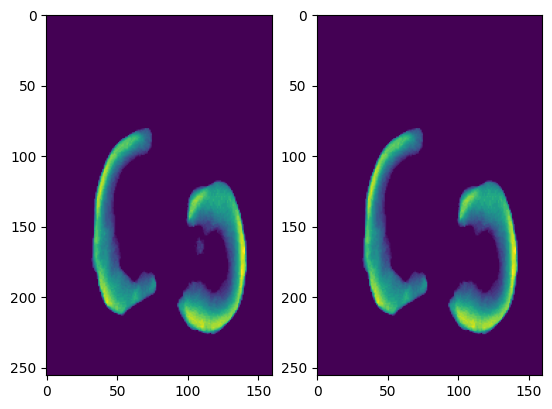

In [ ]:
plt.subplots(1, 2)
#plt.subplot(1, 3, 1)
#plt.imshow(np.sum(seg, axis=0))
plt.subplot(1, 2, 1)
plt.imshow(np.sum(mask, axis=0))
plt.subplot(1, 2, 2)
plt.imshow(np.sum(post_proc_mask, axis=0))

In [ ]:
number_correct = 0
for i, row in CCDF.iterrows():
  if row['ground-truth'] == row['final_unet_aug_test_preds']:
    print("TRUE")
    number_correct += 1
  else:
    print("FALSE")

TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
FALSE
FALSE
TRUE
TRUE
TRUE
FALSE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE
TRUE


In [ ]:
number_correct

25

In [ ]:
number_correct/len(test_dataset)

0.8928571428571429